<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Stock_Analysis/Nifty100_Buy_Sell_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

mypf = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Stock_Analysis/data/Nifty100Scrips.csv')

mypf = mypf[mypf['InScope'] == 1]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol']

#stock_ids

stock_ids = stock_n100

In [3]:
# import necessary libraries 

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
import talib 
yfin.pdr_override()

In [4]:
def MovingAverageCrossStrategy(stock_symbol = 'ULTRACEMCO.NS', start_date = '2018-01-01', end_date = '2020-01-01', 
                               short_window = 20, mid_window = 50, long_window = 200, moving_avg = 'SMA', display_table = True):
    '''
    The function takes the stock symbol, time-duration of analysis, 
    look-back periods and the moving-average type(SMA or EMA) as input 
    and returns the respective MA Crossover chart along with the buy/sell signals for the given period.
    '''
    # stock_symbol - (str)stock ticker as on Yahoo finance. Eg: 'ULTRACEMCO.NS' 
    # start_date - (str)start analysis from this date (format: 'YYYY-MM-DD') Eg: '2018-01-01'
    # end_date - (str)end analysis on this date (format: 'YYYY-MM-DD') Eg: '2020-01-01'
    # short_window - (int)lookback period for short-term moving average. Eg: 5, 10, 20 
    # long_window - (int)lookback period for long-term moving average. Eg: 50, 100, 200
    # moving_avg - (str)the type of moving average to use ('SMA' or 'EMA')
    # display_table - (bool)whether to display the date and price table at buy/sell positions(True/False)

    calc_date = (datetime.datetime.strptime(start_date, '%Y-%m-%d') + datetime.timedelta(days=-200)).strftime('%Y-%m-%d')

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, calc_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-'))) 
    stock_df = web.DataReader(stock_symbol,  data_source='yahoo', start = start, end = end)['Close']
    stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 
                        
    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  
  
    if moving_avg == 'SMA':
        # Create a short simple moving average column
        stock_df[short_window_col] = stock_df['Close Price'].rolling(window = short_window, min_periods = 1).mean()
        
        stock_df[mid_window_col] = stock_df['Close Price'].rolling(window = mid_window, min_periods = 1).mean()

        # Create a long simple moving average column
        stock_df[long_window_col] = stock_df['Close Price'].rolling(window = long_window, min_periods = 1).mean()

    elif moving_avg == 'EMA':
        # Create short exponential moving average column
        stock_df[short_window_col] = stock_df['Close Price'].ewm(span = short_window, adjust = False).mean()
        
        stock_df[mid_window_col] = stock_df['Close Price'].ewm(span = mid_window, adjust = False).mean()

        # Create a long exponential moving average column
        stock_df[long_window_col] = stock_df['Close Price'].ewm(span = long_window, adjust = False).mean()

    # create a new column 'Signal' such that if faster moving average is greater than slower moving average 
    # then set Signal as 1 else 0.
    stock_df['Signal'] = 0.0  
    stock_df['Signal'] = np.where((stock_df[long_window_col] > stock_df[mid_window_col])
                                , 1.0, stock_df['Signal']) 
    
    stock_df['Signal'] = np.where( (stock_df[long_window_col] < stock_df[mid_window_col])
                                  , -1.0, stock_df['Signal']) 

    # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
    stock_df['Position'] = stock_df['Signal'].diff()

    stock_df = stock_df[stock_df.index >= start_date]

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    stock_df['Close Price'].plot(color = 'k', lw = 1, label = 'Close Price')  
    #stock_df[short_window_col].plot(color = 'g', lw = 1, label = short_window_col)
    stock_df[mid_window_col].plot(color = 'm', lw = 1, label = mid_window_col)
    stock_df[long_window_col].plot(color = 'b', lw = 1, label = long_window_col) 
    
    # plot 'buy' signals
    plt.plot(stock_df[stock_df['Position'] >= 1].index, 
            stock_df['Close Price'][stock_df['Position'] >= 1], 
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(stock_df[stock_df['Position'] <= -1].index, 
            stock_df['Close Price'][stock_df['Position'] <= -1], 
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(str(stock_symbol) + ' - ' + str(moving_avg) + ' Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()
    
    if display_table == True:
        print(stock_symbol)
        df_pos = stock_df[(stock_df['Position'] >= 1) | (stock_df['Position'] <= -1)]
        df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
        df_pos = df_pos[df_pos['Signal'] != 0]
        df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
        df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
        df_pos.drop('Prev_Signal', axis=1, inplace=True)
        df_pos.drop(short_window_col, axis=1, inplace=True)
        print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))
        
def plot_buy_sell(stock_id, start_date, table):
    
    #start_date = '2011-01-01'
    #end_date = '2020-03-01'    
    end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    strategy = 'SMA'
    short_window = 20
    mid_window = 50
    long_window = 200
    MovingAverageCrossStrategy(stock_id, start_date, end_date, short_window, mid_window, long_window, strategy, display_table = table)
 

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


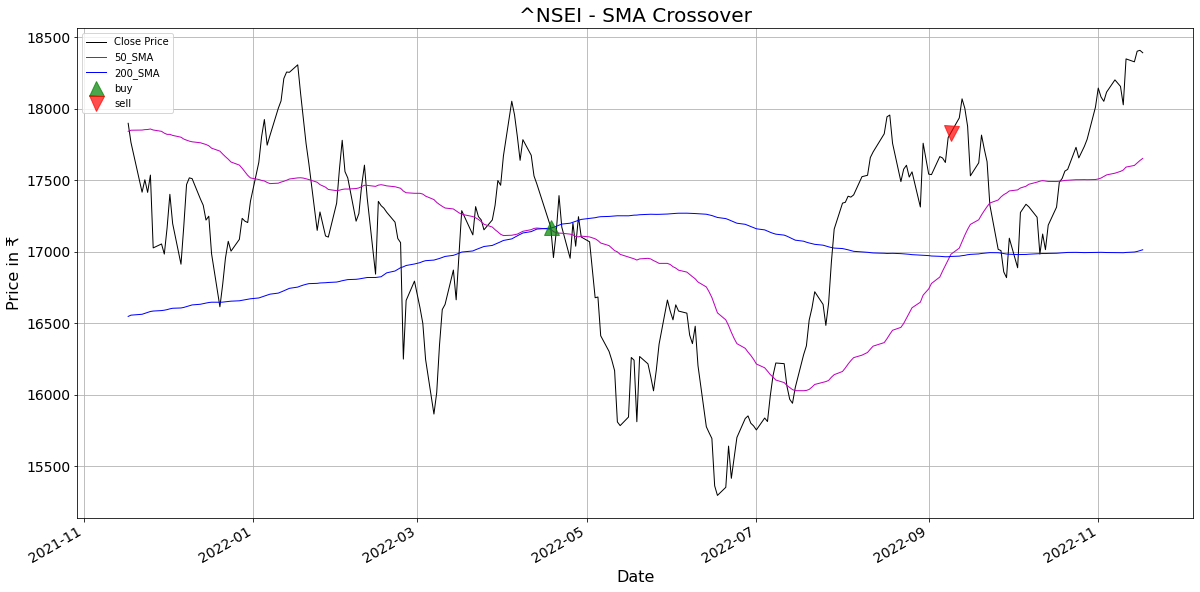

^NSEI
+---------------------+---------------+----------+-----------+----------+------------+
| Date                |   Close Price |   50_SMA |   200_SMA |   Signal | Position   |
|---------------------+---------------+----------+-----------+----------+------------|
| 2022-04-18 00:00:00 |       17173.7 |  17157.3 |   17164.7 |        1 | Buy        |
| 2022-09-09 00:00:00 |       17833.3 |  16982   |   16966.6 |       -1 | Sell       |
+---------------------+---------------+----------+-----------+----------+------------+


In [6]:
start_date = (datetime.date.today() + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
stock_id = '^NSEI'
plot_buy_sell(stock_id, start_date, True)

In [7]:
def get_buy_sell_signal(stock_symbol, start_date, end_date, moving_avg, short_window, mid_window,long_window):

    stock_df = web.DataReader(stock_symbol,  data_source='yahoo', start = start_date, end = end_date)['Close']
    stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  

    if moving_avg == 'SMA':
        # Create a short simple moving average column
        stock_df[short_window_col] = stock_df['Close Price'].rolling(window = short_window, min_periods = 1).mean()
        
        stock_df[mid_window_col] = stock_df['Close Price'].rolling(window = mid_window, min_periods = 1).mean()

        # Create a long simple moving average column
        stock_df[long_window_col] = stock_df['Close Price'].rolling(window = long_window, min_periods = 1).mean()

    elif moving_avg == 'EMA':
        # Create short exponential moving average column
        stock_df[short_window_col] = stock_df['Close Price'].ewm(span = short_window, adjust = False).mean()
        
        stock_df[mid_window_col] = stock_df['Close Price'].rolling(window = mid_window, min_periods = 1).mean()

        # Create a long exponential moving average column
        stock_df[long_window_col] = stock_df['Close Price'].ewm(span = long_window, adjust = False).mean()

    # create a new column 'Signal' such that if faster moving average is greater than slower moving average 
    # then set Signal as 1 else 0.
    stock_df['Signal'] = 0.0  
    stock_df['Signal'] = np.where((stock_df[mid_window_col] < stock_df[long_window_col]), 1.0, stock_df['Signal']) 
    
    stock_df['Signal'] = np.where((stock_df[mid_window_col] > stock_df[long_window_col]), -1.0, stock_df['Signal']) 

    # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
    stock_df['Position'] = stock_df['Signal'].diff()
    
    df_pos = stock_df[(stock_df['Position'] >= 1) | (stock_df['Position'] <= -1)]
    df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)
    df_pos.drop(short_window_col, axis=1, inplace=True)
        
    df_pos['Stock'] = stock_symbol
    return df_pos.tail(1)

In [8]:
start_date = (datetime.date.today() + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
moving_avg = 'SMA'
short_window = 20
mid_window = 50
long_window = 200

df_buy_sell = pd.DataFrame()

for stock_id in stock_ids:
    stock_id = stock_id.upper() + '.NS'
    tmp = get_buy_sell_signal(stock_id, start_date, end_date, moving_avg, short_window, mid_window, long_window)
    df_buy_sell = df_buy_sell.append(tmp)
    
df_buy_sell.sort_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Close Price,50_SMA,200_SMA,Signal,Position,Stock
Date,,,,,,
2022-01-28,3940.699951,4549.294014,4553.500996,1.0,Buy,DIVISLAB.NS
2022-01-28,143.250000,164.429000,164.745098,1.0,Buy,IBREALEST.NS
2022-01-28,1438.400024,1484.863003,1487.889218,1.0,Buy,MUTHOOTFIN.NS
2022-01-28,4406.100098,5498.277998,5518.801959,1.0,Buy,NAUKRI.NS
2022-01-28,3724.199951,4501.233984,4510.797047,1.0,Buy,MINDTREE.NS
...,...,...,...,...,...,...
2022-10-24,2479.850098,2512.837017,2513.896509,1.0,Buy,RELIANCE.NS
2022-10-27,4491.200195,4266.543984,4260.835002,-1.0,Sell,DRREDDY.NS
2022-11-01,894.549988,836.002001,835.096749,-1.0,Sell,MCDOWELL-N.NS


In [9]:
df_buy_sell[df_buy_sell['Position'] == 'Buy'].sort_index().tail(20)

,Close Price,50_SMA,200_SMA,Signal,Position,Stock
Date,,,,,,
2022-01-28,143.250000,164.429000,164.745098,1.0,Buy,IBREALEST.NS
2022-01-28,1438.400024,1484.863003,1487.889218,1.0,Buy,MUTHOOTFIN.NS
2022-01-28,3940.699951,4549.294014,4553.500996,1.0,Buy,DIVISLAB.NS
2022-01-28,620.450012,663.283002,664.219609,1.0,Buy,HDFCLIFE.NS
2022-02-11,905.700012,928.669003,929.186888,1.0,Buy,MOTILALOFS.NS
2022-02-14,541.700012,638.818004,639.126615,1.0,Buy,WIPRO.NS
2022-02-16,98.650002,106.320000,106.362500,1.0,Buy,SAIL.NS
2022-02-25,1389.699951,1583.291006,1584.341554,1.0,Buy,TECHM.NS
2022-03-07,492.399994,590.317000,591.248682,1.0,Buy,GODREJIND.NS


In [10]:
df_buy_sell[df_buy_sell['Position'] == 'Sell'].sort_index().tail(20)

,Close Price,50_SMA,200_SMA,Signal,Position,Stock
Date,,,,,,
2022-08-29,2700.350098,2387.030005,2377.346671,-1.0,Sell,PIDILITIND.NS
2022-09-01,3446.550049,3128.546997,3119.653545,-1.0,Sell,ASIANPAINT.NS
2022-09-02,1382.300049,1246.600000,1244.992424,-1.0,Sell,HAVELLS.NS
2022-09-05,245.300003,218.991001,218.310553,-1.0,Sell,CANBK.NS
2022-09-07,1958.099976,1772.222004,1769.741251,-1.0,Sell,LT.NS
2022-09-08,779.750000,715.837000,715.247999,-1.0,Sell,AXISBANK.NS
2022-09-09,4386.100098,4135.690010,4132.620764,-1.0,Sell,DMART.NS
2022-09-12,1924.000000,1824.964998,1820.097998,-1.0,Sell,KOTAKBANK.NS
2022-09-13,2705.550049,2376.657993,2372.927497,-1.0,Sell,TITAN.NS


[*********************100%***********************]  1 of 1 completed


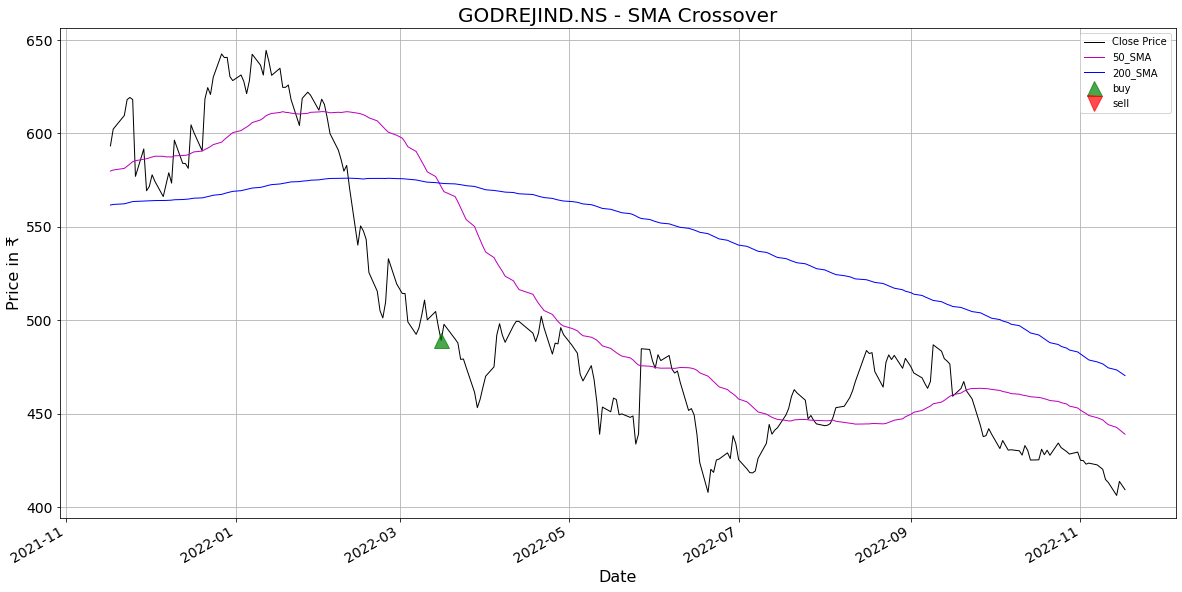

GODREJIND.NS
+---------------------+---------------+----------+-----------+----------+------------+
| Date                |   Close Price |   50_SMA |   200_SMA |   Signal | Position   |
|---------------------+---------------+----------+-----------+----------+------------|
| 2022-03-16 00:00:00 |        489.15 |  571.426 |   573.295 |        1 | Buy        |
+---------------------+---------------+----------+-----------+----------+------------+


In [11]:
start_date = (datetime.date.today() + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
stock_id = 'GODREJIND.NS'
plot_buy_sell(stock_id, start_date, True)